In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from beam import interactions
from propagation import laser
from ionization import ionization
from lens import design
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
plt.style.use('notes')

path = '/mnt/md0/Data/rariniello/TPL/Bessel_Beam/'
lam = 0.796
# All length units are in um

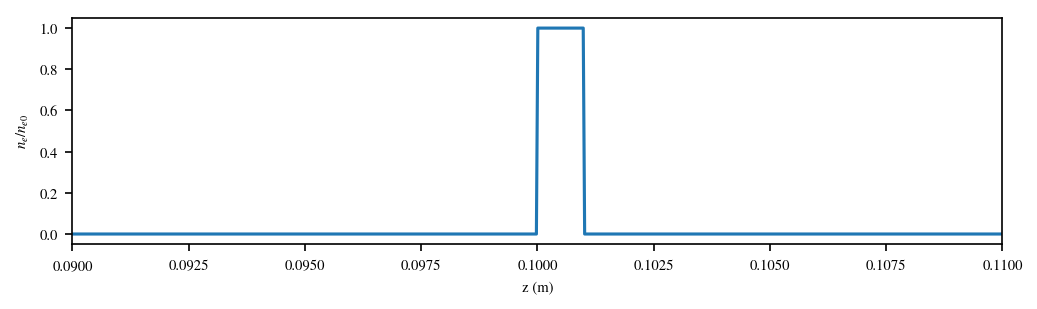

In [2]:
# Plasma density of 1e20
# Helium gas to minimize the effect of beam ionization
length = 1e3
width = 65

# Create the grid for the setup
Nz = 2**15
Z = 1e6 # Needs to be very large to provide resolution in the frequency domain
z, dz = np.linspace(0, Z, Nz, retstep=True)
frac_l = np.zeros(Nz, dtype='double')

# On axis plasma density profile is given by
# Uniform accelerating plasma
z0 = 0.1e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
frac_l[sel_u] = 1.0

xlim = [0.09, 0.11]
#xlim = [2.4, 4]
#xlim = [3.25, 4]
#xlim = [2, 2.5]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, frac_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.show()

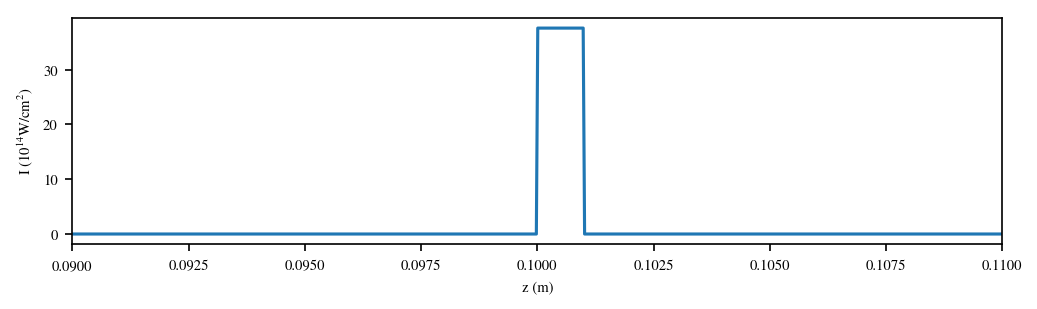

In [3]:
# Calculate the desired on axis intensity profile from the ionization fraction
# Assume a pulse with a Gaussian temporal shape
tau = 70 # RMS pulse length in fs
ion = {'atom' : ionization.He,
       'tau' : tau,
       'type' : 'gaussian'}
I_l = 2*ionization.intensity_from_density(ion, 0.999*frac_l)
sel = I_l < 1
I_l[sel] = 0.0

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()
# Double the calculated intensity to account for absorption by the laser during ionization

In [4]:
def calculate_tran_field(z, I, R, width, lam, path, dk=None, xlim=None, rlim=None):
    """ Calculate the transverse field from an desired on-axis intensity.
    
    Parameters
    ----------
    z : array of doubles
        Z positions corresponding to the intensity array (must be evenly spaced).
    I : array of doubles
        The desired on axis intensity distribution.
    R : double
        The maximum radius to calculate the field at, in um.
    width : double
        The width of the plasma in um, measured from the zeros of the Bessel function.
    lam : double
        The laser wavelength in um.
    dk : optional, double
        The range of spatial frequencies to plot.
    xlim : optional, tuple or array
        Bounds of z-axis plots.
    rlim : optional, tuple or array
        The limits for the transverse field plot
        
    Returns
    -------
    r : array of doubles
        Radius values for the electric field array.
    E : array of complex128
        The electric field at each radius.
    """
    # Calculate and display the kz spectrum
    #--------------------------------------------------------------------------
    params = {
        'Nr' : 5000,
        'R' : R,
        'w' : width,
        'lam' : lam
    }
    Nz = len(z)
    r = np.linspace(0, params['R'], params['Nr'])
    E = np.zeros(params['Nr'], dtype='complex128')
    Ez = ionization.field_from_intensity(I)
    k = 2*np.pi/lam
    dz = z[1] - z[0]
    # Shift frequencies
    kr0 = 2.4048 / params['w']
    kz0 = np.sqrt(k**2 - kr0**2)
    kz = 2*np.pi * fftshift(fftfreq(Nz, dz)) + kz0
    e = fftshift(fft(Ez)) / Nz
    
    plt.figure(figsize=(8, 2), dpi=150)
    plt.plot(kz, ionization.intensity_from_field(e))
    plt.xlabel(r'$k_z$ ($\mu m^{-1}$)')
    plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
    plt.xlim(k-dk, k)
    plt.show()
    
    # Calculate the required transverse field and show the actual longitudinal profile
    #--------------------------------------------------------------------------
    r, E = bessel.bessel_expansion(params, z, I)
    zFres = np.linspace(0.09e6, 0.11e6, 1000)
    eFres = laser.fresnel_axis(E, r, zFres, lam)
    IFres = ionization.intensity_from_field(eFres)
    
    plt.figure(figsize=(8, 2), dpi=150)
    plt.plot(z/1e6, I)
    plt.plot((zFres+z[0])/1e6, IFres, 'm')
    plt.legend(['Target intensity', 'Actual intensity'])
    plt.xlabel(r'z (m)')
    plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
    # Plot the transverse phase and intensity
    #--------------------------------------------------------------------------
    # Radial dependence of the phase and and intensity after the beam shaping optics
    if rlim is None:
        rlim = [0, R/1e3]
    plt.figure(figsize=(8, 2), dpi=150)
    plt.subplot(121)
    plt.plot(r/1e3, ionization.intensity_from_field(E))
    plt.xlabel(r'r (mm)')
    plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
    plt.xlim(rlim)
    plt.subplot(122)
    plt.plot(r/1e3, np.unwrap(np.angle(E)))
    plt.xlabel(r'r (mm)')
    plt.ylabel(r'$\phi$ (radians)')
    plt.xlim(rlim)
    plt.tight_layout()
    plt.show()

    return r, E

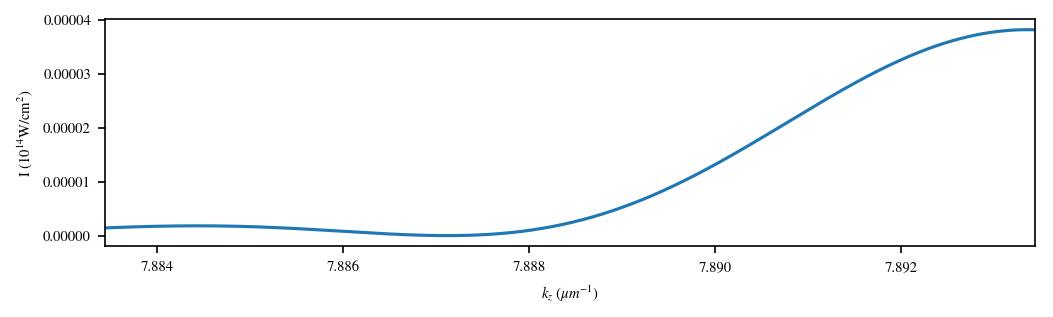

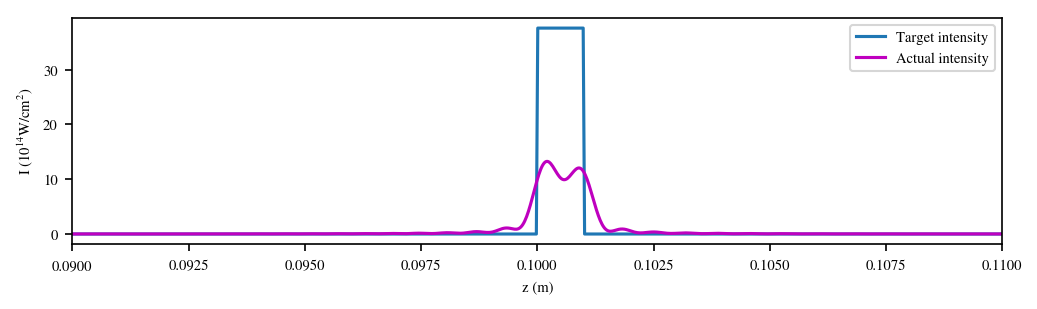

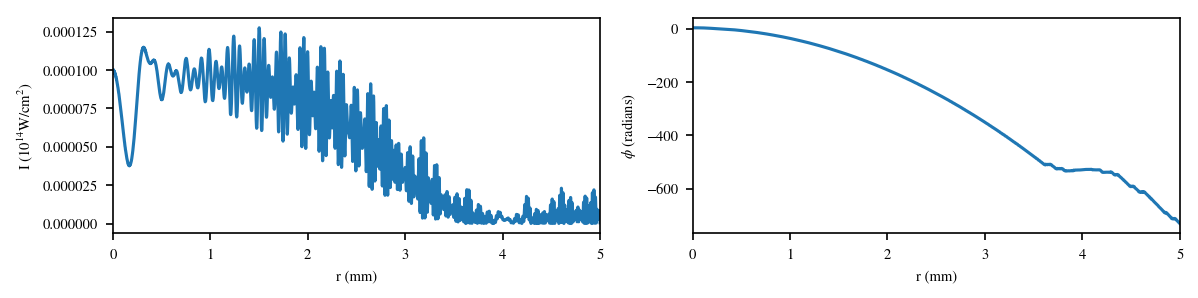

In [5]:
# Optic design upstream
r, E = calculate_tran_field(z, I_l, 5e3, width, lam, path, 1e-2, xlim, [0, 5])